# Introduction to Machine Learning - Exercise 5
* Goal of the excercise is to learn how to use **K-means** implementation in the Scikit-learn library to perform clustering and subsequent cluster analysis on a Titanic dataset.

## 🔎 Let's discuss the clustering topic a bit first
* What task do clustering algorithms solve?
* Do you know any examples of such algorithms?
* What are the limitation of clustering algorithms?

## 🔎 What is the **most difficult** of the clustering tasks?

![meme01](https://github.com/lubsar/EFREI-Introduction-to-Machine-Learning/blob/main/images/fml_04_meme_01.jpg?raw=true)

## 💡 But don't worry we will deal with the topic in several lectures 😊

## Import the libraries
* 🔎  What is the **sklearn** library?

In [43]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.preprocessing, sklearn.cluster, sklearn.metrics
import scipy.spatial
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# We will work with the famous Titanic dataset ⛵

## Data Dictionary

|Variable|Definition|Key|
|:-------|:-------|:--------|
|survival|Survival|0 = No, 1 = Yes|
|pclass|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd|
|sex|Sex||
|Age|Age in years||
|sibsp|# of siblings / spouses aboard the Titanic||
|parch|# of parents / children aboard the Titanic||
|ticket|Ticket number||
|fare|Passenger fare||
|cabin|Cabin number||
|embarked|Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton|

**pclass**: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

* Dataset is available at https://www.kaggle.com/competitions/titanic'

## Load dataset
* https://raw.githubusercontent.com/rasvob/EFREI-Introduction-to-Machine-Learning/main/datasets/titanic.csv

In [44]:
df = pd.read_csv('https://raw.githubusercontent.com/lubsar/EFREI-Introduction-to-Machine-Learning/main/datasets/titanic.csv', index_col=0)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## How many missing values do we have in the data?

In [45]:
df.isna().sum().sort_values(ascending=False)

,0
Cabin,687
Age,177
Embarked,2
Name,0
Pclass,0
Survived,0
Sex,0
Parch,0
SibSp,0
Fare,0


## We are going to cluster the passangers into defined number of groups
* It is clear that it is mandatory to select only a relevant subset of features
    * Name the new DF as *df_clustering*
* 🔎 Is *Name* or *Ticket* relevant?
    * 'Survived', 'Pclass','Sex','Age','SibSp','Parch','Fare','Embarked'

1. Select the features
2. Drop *NaN* values
3. Change type of *Sex* and *Embarked* to string
    * **astype()** function

In [46]:
df_clustering = df[['Survived', 'Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']].copy()
df_clustering = df_clustering.dropna()
df_clustering.Sex = df_clustering.Sex.astype(str)
df_clustering.Embarked = df_clustering.Embarked.astype(str)
df_clustering.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


## Check *shape* and *dtypes*

In [47]:
df_clustering.shape

(712, 8)

In [48]:
df_clustering.dtypes

,0
Survived,int64
Pclass,int64
Sex,object
Age,float64
SibSp,int64
Parch,int64
Fare,float64
Embarked,object


# Print the dataset

## 🔎 Does everything seem OK?

In [49]:
df_clustering

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,3,female,39.0,0,5,29.1250,Q
887,0,2,male,27.0,0,0,13.0000,S
888,1,1,female,19.0,0,0,30.0000,S


# We can see that not all features are numerical
* 🔎 Is it a problem?
    * Why?
* 🔎 How to deal with it?

## We have two basic encoding options
* Ordinal encoding vs. One-hot encoding
* What is the difference?
    * Is thete difference in dimensionality change? Why it can be an issue?
    * When is ordinal encoding appropriate?
    * Can you omit the pre-requirements of ordinal encoding sometimes?

## Lets encode categorical features
* https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing
* https://scikit-learn.org/stable/modules/classes.html?highlight=preprocessing#module-sklearn.preprocessing



In [50]:
enc = sklearn.preprocessing.OrdinalEncoder()
enc.fit_transform(df_clustering[['Sex']])[:20]

array([[1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.]])

In [51]:
enc.categories_

[array(['female', 'male'], dtype=object)]

## 💡 You may ask why do we use the `dataframe[['feature_name']]` notation with double `[[` and `]]` brackets
* **Single brackets** pair around one variable name means that you want to select just the `pandas.Series` object

In [52]:
type(df_clustering['Sex'])

pandas.core.series.Series

* **Double brackets** pair around one variable name created an output in the `pandas.DataFrame` format

In [53]:
type(df_clustering[['Sex']])

pandas.core.frame.DataFrame

## There is OneHotEncoder as well, however I recommend using `pd.get_dummies` method instead

In [54]:
pd.get_dummies(df_clustering[['Embarked']]).head()

,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,
1,False,False,True
2,True,False,False
3,False,False,True
4,False,False,True
5,False,False,True


## Let's finish the encoding part and create a new dataframe with encoded data
1. Create empty *df_encoded* dataframe with index using *df_clustering.index*
2. Create *Sex* variable with ordinal encoded data
3. Use `join` method for added one-hot encoded *Embarked* feature

In [55]:
df_encoded = pd.DataFrame(index = df_clustering.index)

In [56]:
df_encoded['Sex'] = sklearn.preprocessing.OrdinalEncoder().fit_transform(df_clustering[['Sex']])

In [57]:
df_encoded = df_encoded.join(pd.get_dummies(df_clustering[['Embarked']]))
df_encoded.head()

,Sex,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,
1,1.0,False,False,True
2,0.0,True,False,False
3,0.0,False,False,True
4,0.0,False,False,True
5,1.0,False,False,True


# It is important to select the appropriate scaling method of the number features
* There are many ways how to do this - **MinMax, StandardScaler, PowerTransform, ...**
* This step heavily depends on a domain knowledge because the scales of the features have significant effect on a distances between couples of dataset instances
    - It is clear that if one variable is in range **(0,1)** and the second one is in a range **(5000, 10 000)**, the difference in the **second feature** will be definitely **more important** than in the  first one from the numerical point of view
    - Although it is possible that from the **domain point of view** the **first variable may be more important**
    - 💡 Thus it is a good idea to at least transform the features into a **simiiar scales so the effect on the distance value would be similiar**
    - Transformation depends heavily on the statistical distribution of the feature
        - 💡You can use PowerTransform for a heavy-tailed distribution, **Standardization or MinMax normalization for normally distributed features** etc.

## Take a look at the *Fare* feature distribution
* What transformation would be appropriate based on that?

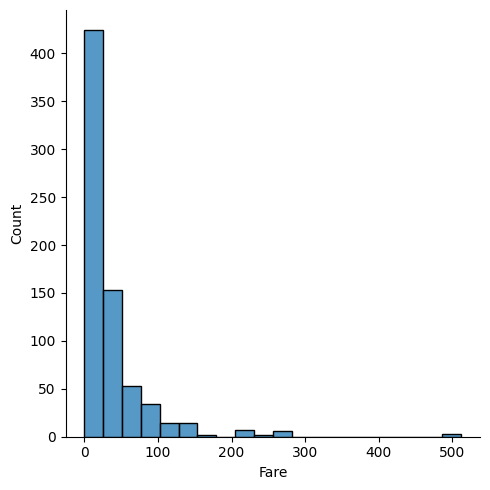

In [58]:
sns.displot(df_clustering.Fare, bins=20)

## Transform the feature

In [59]:
enc = sklearn.preprocessing.PowerTransformer()
enc.fit_transform(df_clustering[['Fare']])[:20]

array([[-0.99765031],
       [ 1.28775742],
       [-0.90107255],
       [ 1.02427568],
       [-0.88411158],
       [ 1.00273178],
       [ 0.13202717],
       [-0.53475875],
       [ 0.48661962],
       [-0.10705645],
       [ 0.36394683],
       [-0.88411158],
       [ 0.52494282],
       [-0.91080102],
       [-0.15160295],
       [ 0.45530075],
       [-0.029469  ],
       [ 0.34315814],
       [-0.36978947],
       [-0.88691511]])

## Add the transformed feature into the *df_encoded* dataframe

In [60]:
df_encoded['Fare'] = sklearn.preprocessing.PowerTransformer().fit_transform(df_clustering[['Fare']])

## Plot histogram of the transformed feature
* 🔎 What has changed?

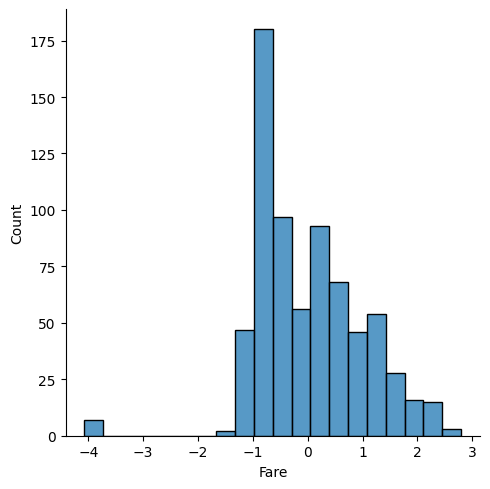

In [61]:
sns.displot(df_encoded.Fare, bins=20)

In [62]:
df_encoded.head()

,Sex,Embarked_C,Embarked_Q,Embarked_S,Fare
PassengerId,,,,,
1,1.0,False,False,True,-0.997650
2,0.0,True,False,False,1.287757
3,0.0,False,False,True,-0.901073
4,0.0,False,False,True,1.024276
5,1.0,False,False,True,-0.884112


In [63]:
df_clustering.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


## Scale the *Age* using MinMax scaler
* `sklearn.preprocessing.minmax_scale`

In [64]:
df_encoded['Age'] = sklearn.preprocessing.minmax_scale(df_clustering.Age)

## Join the *df_encoded* and *['Survived', 'Pclass', 'SibSp', 'Parch']* features

In [65]:
df_encoded = df_encoded.join(df_clustering[['Survived', 'Pclass', 'SibSp', 'Parch']])
df_encoded.head()

,Sex,Embarked_C,Embarked_Q,Embarked_S,Fare,Age,Survived,Pclass,SibSp,Parch
PassengerId,,,,,,,,,,
1,1.0,False,False,True,-0.997650,0.271174,0,3,1,0
2,0.0,True,False,False,1.287757,0.472229,1,1,1,0
3,0.0,False,False,True,-0.901073,0.321438,1,3,0,0
4,0.0,False,False,True,1.024276,0.434531,1,1,1,0
5,1.0,False,False,True,-0.884112,0.434531,0,3,0,0


# We finally got to the clustering part 😮‍💨

![meme02](https://github.com/lubsar/EFREI-Introduction-to-Machine-Learning/blob/main/images/fml_04_meme_02.jpg?raw=true)

## There are methods how to identify probable number of clusters in the data
* It is always a rough estimate

## 💡 We can use **Elbow method** to identify potentially ideal number of clusters in our data in **KMeans** algorithm.

There are two basic methods for evaluation of clusters quality:
1. SSE - Sum of squared distances of samples to their closest cluster center, this one is specific for **KMeans** algorithm.
    * You can find it as **inertia_** attribute of KMeans sklearn object.
2. Silhouette Coefficient - calculated using the mean intra-cluster distance and the mean nearest-cluster distance

## 💡 We ussually want to find number of clusters with low SSE and high Silhoutte coef.
- Take a look at [this](https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c) and [this](https://towardsdatascience.com/k-means-clustering-from-a-to-z-f6242a314e9a) for more details

## Try different number of clusters from range <2, 10> for KMeans algorithm, save both evaluation criteria and plot dependency of criteria to number of clusters.
* We will use `sklearn.cluster.KMeans` class
* The most important parameter is the *n_clusters*
    * What is the *random_state* parameter?

In [66]:
X = df_encoded.values

In [67]:
clustering_scores = []
for k in range(2, 11):
    clustering = sklearn.cluster.KMeans(n_clusters=k, random_state=13).fit(X)
    clustering_scores.append({
        'k': k,
        'sse': clustering.inertia_,
        'silhouette': sklearn.metrics.silhouette_score(X, clustering.labels_)
    })
df_clustering_scores = pd.DataFrame.from_dict(clustering_scores, orient='columns')
df_clustering_scores = df_clustering_scores.set_index('k')

In [68]:
df_clustering_scores

,sse,silhouette
k,,
2,2051.762020,0.334082
3,1580.250928,0.364262
4,1360.796955,0.379880
5,1220.122090,0.267616
6,1138.545101,0.248358
7,1043.928558,0.277009
8,1000.976087,0.286154
9,932.731933,0.294794
10,883.114822,0.296287


## Plot the SSE and Silhouette score

<Axes: xlabel='k', ylabel='sse'>

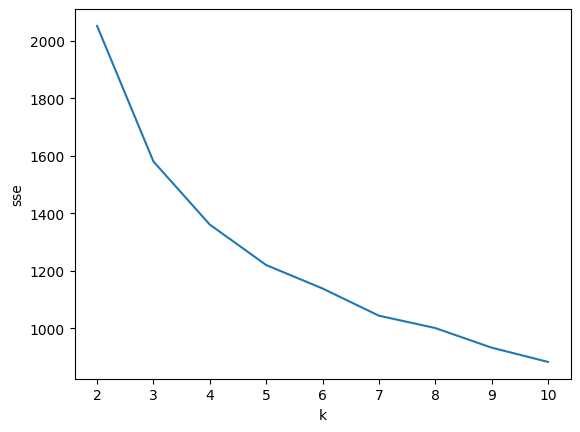

In [69]:
sns.lineplot(data = df_clustering_scores, y='sse', x='k')

<Axes: xlabel='k', ylabel='silhouette'>

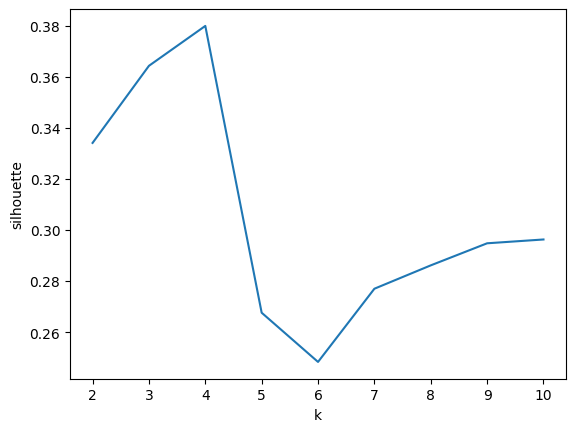

In [70]:
sns.lineplot(data = df_clustering_scores, y='silhouette', x='k')

# 🔎 What is the probable number of clusters in the data?

## Let's try to analyze the data assigned into **4** clusters

In [71]:
clustering = sklearn.cluster.KMeans(n_clusters=4, random_state=13)
clustering.fit(X)

KMeans(n_clusters=4, random_state=13)

## How big are our clusters? How many 0, 1, .. are in *labels_* property?

In [72]:
pd.Series(clustering.labels_).value_counts()

,count
0,396
1,229
2,44
3,43


# 📒 Explore clusters
* Try to use cluster information for exploration analysis of our data
    * Create new feature *cluster_id* with the *labels_* property data

In [73]:
df_clustering['cluster_id'] = clustering.labels_
df_clustering.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,cluster_id
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,0
2,1,1,female,38.0,1,0,71.2833,C,1
3,1,3,female,26.0,0,0,7.9250,S,0
4,1,1,female,35.0,1,0,53.1000,S,1
5,0,3,male,35.0,0,0,8.0500,S,0


## 🚀 Hint: You can use *sns.countplot* as a visual *.value_counts()* method

<Axes: xlabel='cluster_id', ylabel='count'>

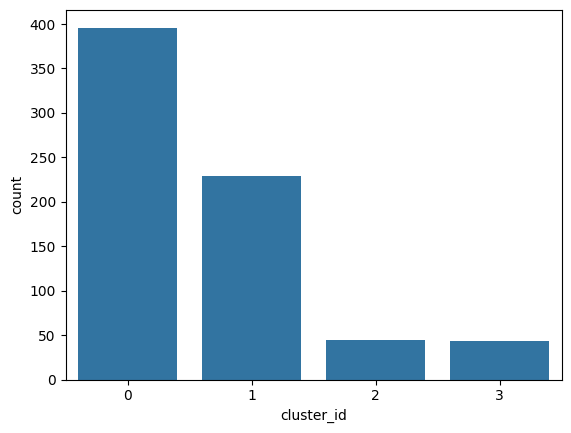

In [74]:
sns.countplot(data=df_clustering, x='cluster_id')

## 🎯 Create plots showing values of different attributes based on cluster group and describe them
* Let's follow the four example questions about the data to solve the task

### ❓ Questions ❓
1. Is **Fare** different for points in different clusters?
    * 💡 Use *plt.yscale('log')* to take care of the outlier/variance effect
2. Is **Age** different for point in different clusters?
3. Does rate of suvival differ in clusters?
    * *Survived*
4. Does number of passanger of each class differ in clusters?
    * *Pclass*

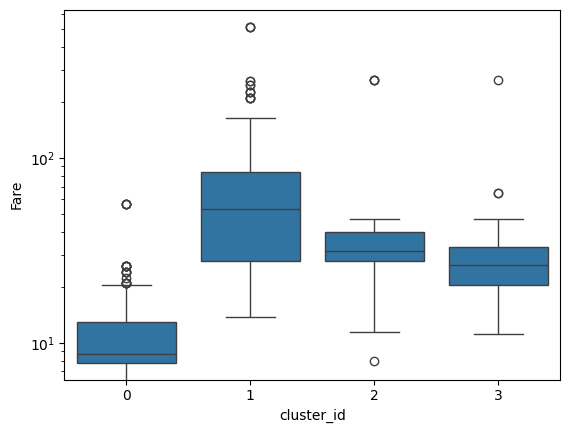

In [75]:
sns.boxplot(data=df_clustering, y='Fare', x='cluster_id')
plt.yscale('log')

<Axes: xlabel='cluster_id', ylabel='Age'>

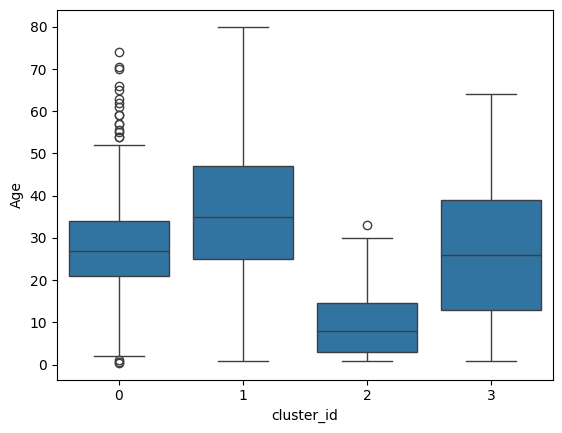

In [76]:
sns.boxplot(data=df_clustering, y='Age', x='cluster_id')

<Axes: xlabel='cluster_id', ylabel='count'>

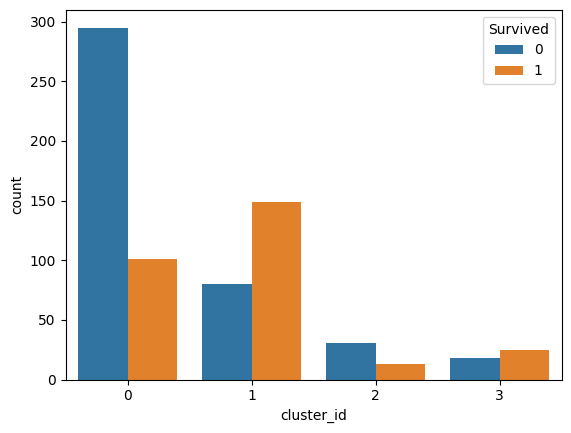

In [77]:
sns.countplot(data=df_clustering, x='cluster_id', hue='Survived')

<Axes: xlabel='cluster_id', ylabel='count'>

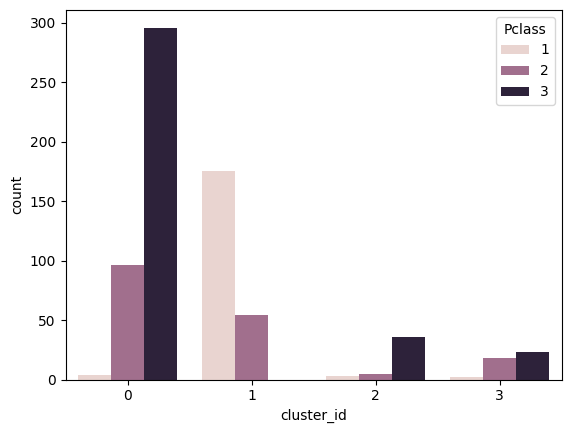

In [78]:
sns.countplot(data=df_clustering, x='cluster_id', hue='Pclass')

In [79]:
df_clustering[df_clustering.cluster_id == 1].Pclass.value_counts()

,count
Pclass,
1,175
2,54


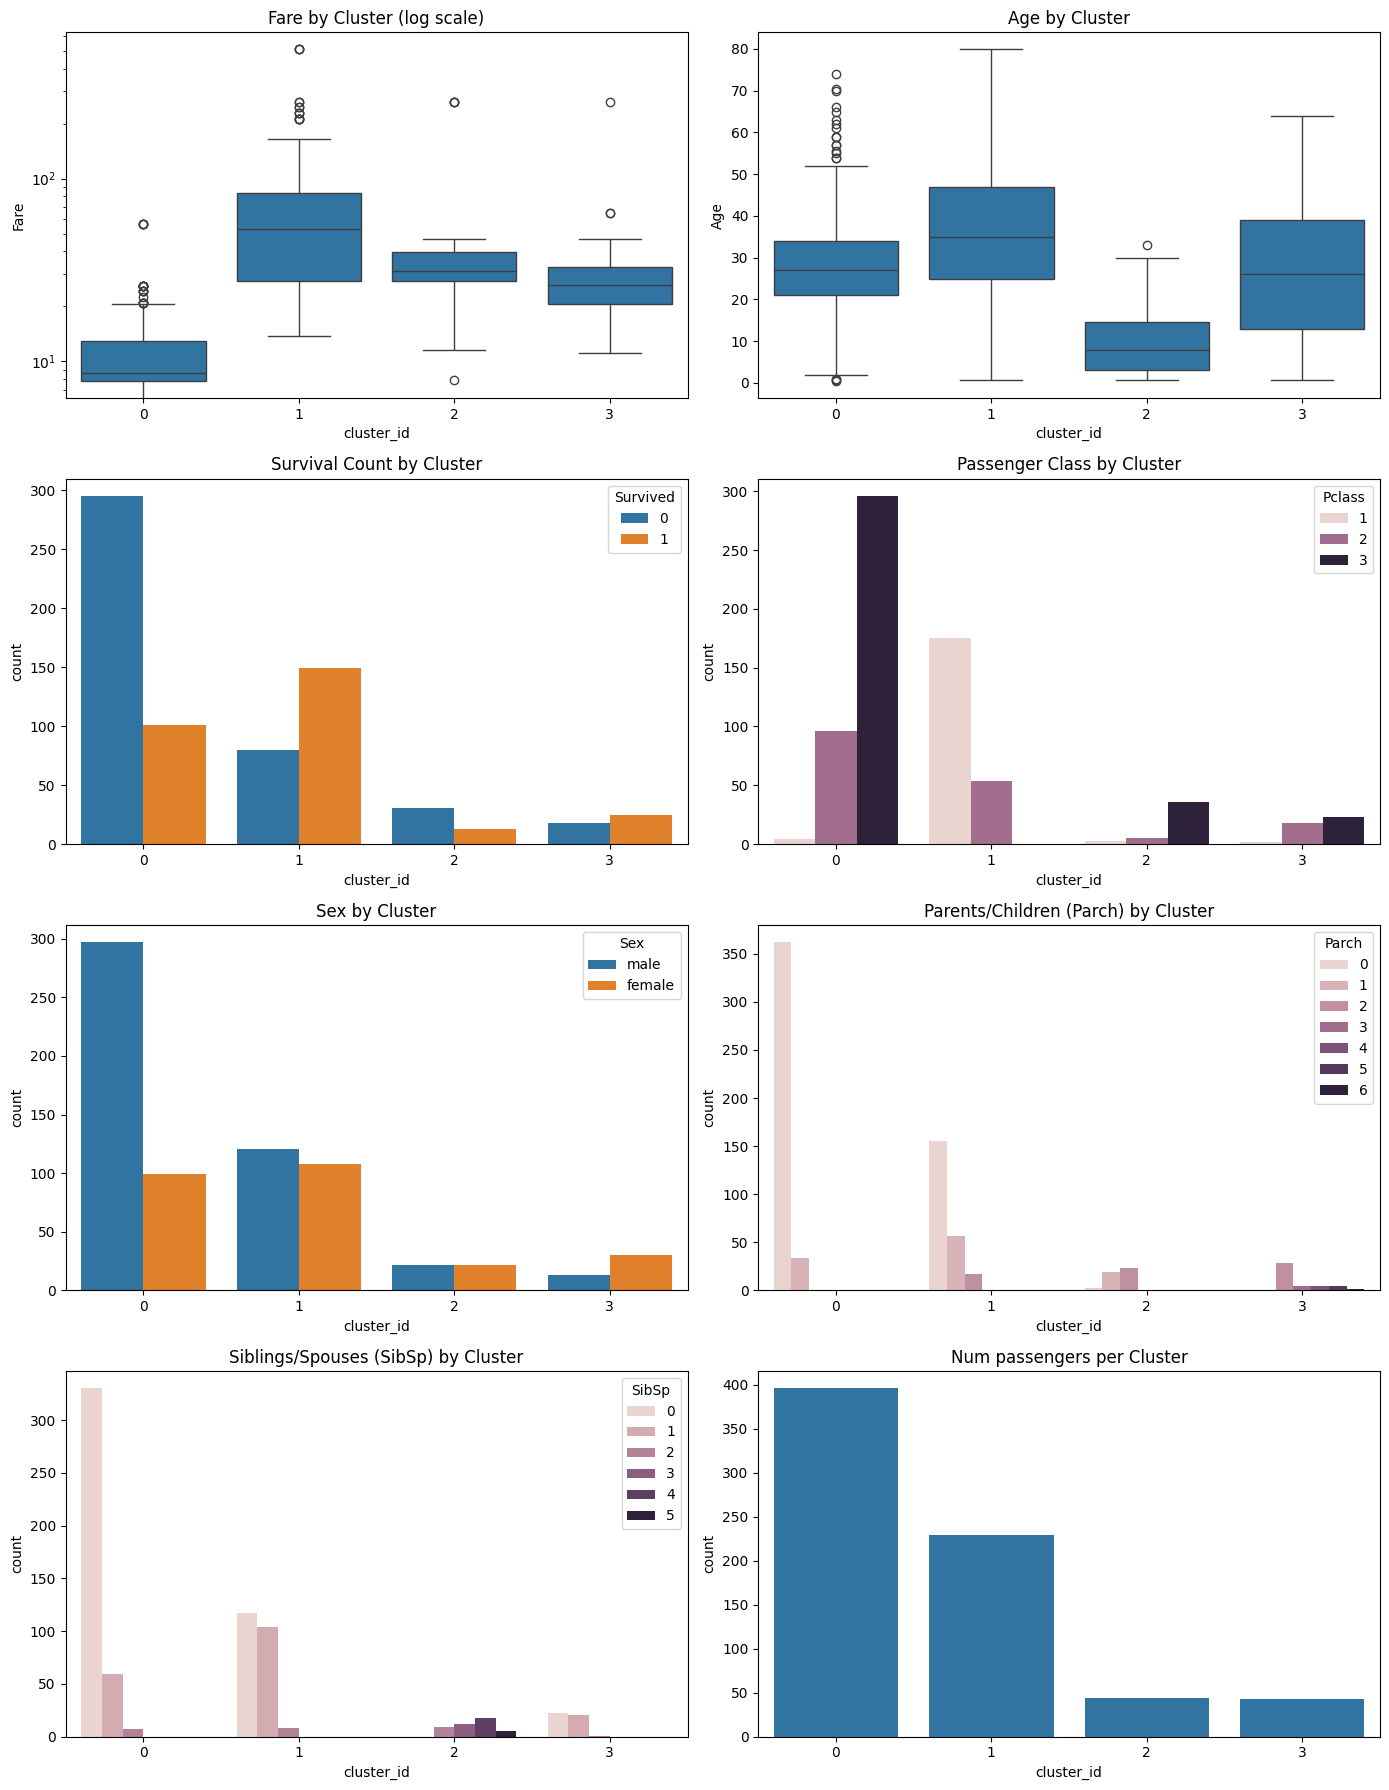

In [80]:
# Create a 4x2 grid of subplots (since you have 7 plots total)
fig, axes = plt.subplots(4, 2, figsize=(14, 18))
axes = axes.flatten()

# 1. Fare vs cluster_id (log scale)
sns.boxplot(data=df_clustering, y='Fare', x='cluster_id', ax=axes[0])
axes[0].set_yscale('log')
axes[0].set_title('Fare by Cluster (log scale)')

# 2. Age vs cluster_id
sns.boxplot(data=df_clustering, y='Age', x='cluster_id', ax=axes[1])
axes[1].set_title('Age by Cluster')

# 3. Survived vs cluster_id
sns.countplot(data=df_clustering, x='cluster_id', hue='Survived', ax=axes[2])
axes[2].set_title('Survival Count by Cluster')

# 4. Pclass vs cluster_id
sns.countplot(data=df_clustering, x='cluster_id', hue='Pclass', ax=axes[3])
axes[3].set_title('Passenger Class by Cluster')

# 5. Sex vs cluster_id
sns.countplot(data=df_clustering, x='cluster_id', hue='Sex', ax=axes[4])
axes[4].set_title('Sex by Cluster')

# 6. Parch vs cluster_id
sns.countplot(data=df_clustering, x='cluster_id', hue='Parch', ax=axes[5])
axes[5].set_title('Parents/Children (Parch) by Cluster')

# 7. SibSp vs cluster_id
sns.countplot(data=df_clustering, x='cluster_id', hue='SibSp', ax=axes[6])
axes[6].set_title('Siblings/Spouses (SibSp) by Cluster')

sns.countplot(data=df_clustering, x='cluster_id', ax=axes[7])
axes[7].set_title('Num passengers per Cluster')

# Adjust layout
plt.tight_layout()
plt.show()

# 📝 Write a textual description of the four clusters

### Cluster 1 - Fare was the lowest, because of the class. Age was in range from 0 to 50, with some outliers with the age above 50, half the passengers were in the range between 20-35.  Contains most of the 3rd class passengers, only a few class 1 passengers and around 100 class 2 passangers. Around 3/4 passengers did not survive.

### Cluster 2 - Contains mostly first and second class passengers. Around 2/3rds of the passengers survived. Age is from 0 to 80, half in the 25-45 years range, median is above 35. With fare in the range from tens - hundred, some in the hundreds.

### Cluster 3 - 3rd class, some second and first, Fare prices in the tens, 1/3rd survived. Children. around 25% young adults (20 - 30).

### Cluster 4 -  3rd class, second and third, Fare prices in the tens but lower than cluster 4, 1/3rd survived. Teens - young adults 15-40 50%, around 60% survival rate.

# Is our data represented in the best way?

* **Clustering methods depends on calculation of distance metric among data points in our data matrix.**
* Therefore it is necessary to preproces our data matrix **X** in a best way possible to achive equal distance for every dataset feature.
    * After such transformation we can presume, that difference in *Age* has same impact as the difference as in the *Fare* feature.
* **Generally, it is very hard to create perfect tranformation for our real dataset.**

## Use StandardScaler transformation for our data **X**

In [81]:
col_names = ['Fare', 'Age', 'SibSp', 'Parch']
enc = sklearn.preprocessing.StandardScaler()
X_stand = pd.DataFrame(enc.fit_transform(df_clustering.loc[:, col_names]), columns = col_names, index=df_clustering.index)
X_stand = pd.concat([X_stand, df_encoded.loc[:, ['Sex', 'Embarked_C', 'Embarked_Q', 'Embarked_S']], df_clustering.Survived], axis=1)

In [82]:
X_stand

,Fare,Age,SibSp,Parch,Sex,Embarked_C,Embarked_Q,Embarked_S,Survived
PassengerId,,,,,,,,,
1,-0.516380,-0.527669,0.522511,-0.506787,1.0,False,False,True,0
2,0.694046,0.577094,0.522511,-0.506787,0.0,True,False,False,1
3,-0.503620,-0.251478,-0.552714,-0.506787,0.0,False,False,True,1
4,0.350326,0.369951,0.522511,-0.506787,0.0,False,False,True,1
5,-0.501257,0.369951,-0.552714,-0.506787,1.0,False,False,True,0
...,...,...,...,...,...,...,...,...,...
886,-0.102875,0.646142,-0.552714,5.350885,0.0,False,True,False,0
887,-0.407687,-0.182430,-0.552714,-0.506787,1.0,False,False,True,0
888,-0.086335,-0.734812,-0.552714,-0.506787,0.0,False,False,True,1


In [83]:
X_stand.describe()

,Fare,Age,SibSp,Parch,Sex,Survived
count,7.120000e+02,7.120000e+02,7.120000e+02,7.120000e+02,712.000000,712.000000
mean,-6.736185e-17,2.943962e-16,-1.496930e-17,1.496930e-17,0.636236,0.404494
std,1.000703e+00,1.000703e+00,1.000703e+00,1.000703e+00,0.481420,0.491139
min,-6.534272e-01,-2.017717e+00,-5.527137e-01,-5.067874e-01,0.000000,0.000000
25%,-5.012575e-01,-6.657639e-01,-5.527137e-01,-5.067874e-01,0.000000,0.000000
50%,-3.576726e-01,-1.133826e-01,-5.527137e-01,-5.067874e-01,1.000000,0.000000
75%,-2.962586e-02,5.770939e-01,5.225108e-01,6.647471e-01,1.000000,1.000000
max,9.031168e+00,3.477095e+00,4.823409e+00,6.522419e+00,1.000000,1.000000


# ✅ Task
1. Use **KMeans** to differently preprocessed data matrix **X_stand**
2. Detect "ideal" number of clusters using Elbow method
3. Explore detected clusters and **describe** them to the Markdown cell
    * **Describe the insight you got from the plots with a few sentences in a Markdown cell below the plot**

,sse,silhouette
k,,
2,2614.505804,0.406254
3,2272.087578,0.238575
4,1895.691273,0.249366
5,1605.488257,0.276669
6,1458.500407,0.263100
7,1327.748823,0.259995
8,1237.922842,0.271237
9,1115.424077,0.286053
10,1034.219167,0.291710


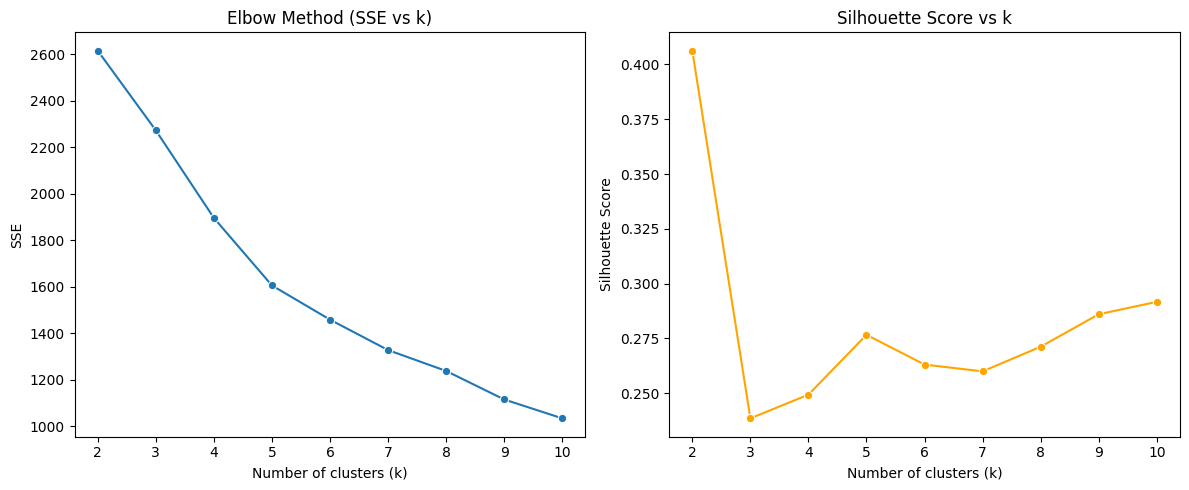

Nombre de passagers par cluster :
1    401
0    185
3    106
2     20
Name: count, dtype: int64


<Figure size 1400x1800 with 0 Axes>

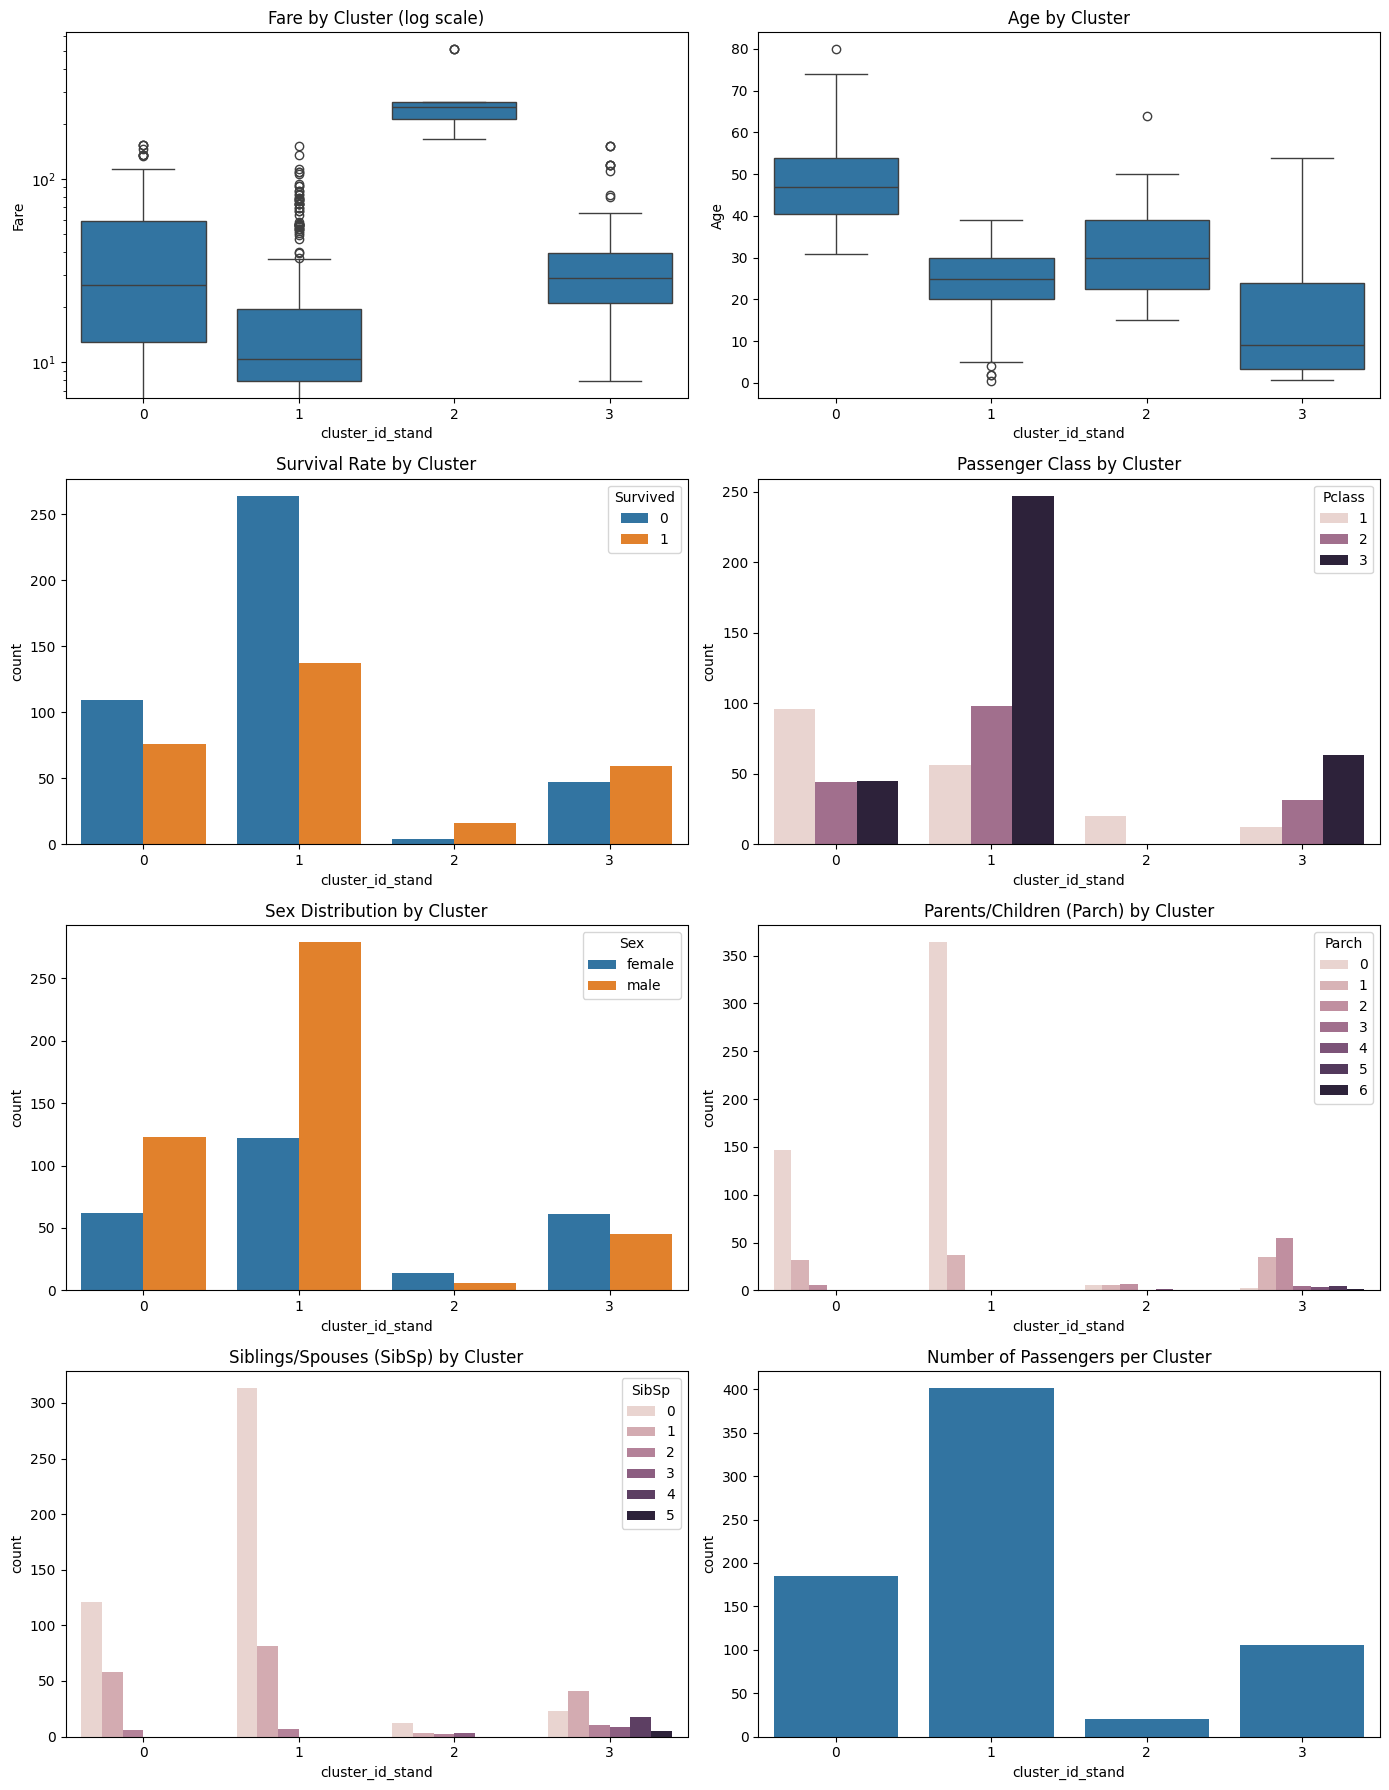

,Fare,Age,SibSp,Parch,Survived
cluster_id_stand,,,,,
0,40.59,47.80,0.38,0.24,0.41
1,19.27,25.09,0.24,0.09,0.34
2,273.33,31.85,0.80,1.20,0.80
3,36.87,14.74,1.75,1.92,0.56


In [84]:
clustering_scores_stand = []

for k in range(2, 11):
    model = KMeans(n_clusters=k, random_state=41, n_init='auto')
    model.fit(X_stand)
    sse = model.inertia_
    sil = silhouette_score(X_stand, model.labels_)
    clustering_scores_stand.append({'k': k, 'sse': sse, 'silhouette': sil})


df_scores_stand = pd.DataFrame(clustering_scores_stand).set_index('k')
display(df_scores_stand)


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.lineplot(data=df_scores_stand, x='k', y='sse', marker='o')
plt.title('Elbow Method (SSE vs k)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE')

plt.subplot(1, 2, 2)
sns.lineplot(data=df_scores_stand, x='k', y='silhouette', marker='o', color='orange')
plt.title('Silhouette Score vs k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()


best_k = 4
kmeans_final = KMeans(n_clusters=best_k, random_state=41, n_init='auto')
kmeans_final.fit(X_stand)

df_clustering['cluster_id_stand'] = kmeans_final.labels_


print("Nombre de passagers par cluster :")
print(pd.Series(kmeans_final.labels_).value_counts())

plt.figure(figsize=(14, 18))
fig, axes = plt.subplots(4, 2, figsize=(14, 18))
axes = axes.flatten()


sns.boxplot(data=df_clustering, y='Fare', x='cluster_id_stand', ax=axes[0])
axes[0].set_yscale('log')
axes[0].set_title('Fare by Cluster (log scale)')


sns.boxplot(data=df_clustering, y='Age', x='cluster_id_stand', ax=axes[1])
axes[1].set_title('Age by Cluster')


sns.countplot(data=df_clustering, x='cluster_id_stand', hue='Survived', ax=axes[2])
axes[2].set_title('Survival Rate by Cluster')


sns.countplot(data=df_clustering, x='cluster_id_stand', hue='Pclass', ax=axes[3])
axes[3].set_title('Passenger Class by Cluster')

sns.countplot(data=df_clustering, x='cluster_id_stand', hue='Sex', ax=axes[4])
axes[4].set_title('Sex Distribution by Cluster')

sns.countplot(data=df_clustering, x='cluster_id_stand', hue='Parch', ax=axes[5])
axes[5].set_title('Parents/Children (Parch) by Cluster')


sns.countplot(data=df_clustering, x='cluster_id_stand', hue='SibSp', ax=axes[6])
axes[6].set_title('Siblings/Spouses (SibSp) by Cluster')


sns.countplot(data=df_clustering, x='cluster_id_stand', ax=axes[7])
axes[7].set_title('Number of Passengers per Cluster')

plt.tight_layout()
plt.show()


df_summary = df_clustering.groupby('cluster_id_stand')[['Fare', 'Age', 'SibSp', 'Parch', 'Survived']].mean().round(2)
display(df_summary)